# Covid19 혹진자 시계열 분석

## 1. 작업 준비
### 1) 패키지 및 데이터 가져오기

In [26]:
import sys
sys.path.append("../../")
from helper import set_datetime_index, exp_time_data

from datetime import datetime as dt
from datetime import timedelta
from pandas import read_excel, to_datetime
from matplotlib import pyplot as plt
from matplotlib import dates as mdates    # 그래프 축을 날짜로 설정하기 위한 모듈
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sb

In [27]:
origin = read_excel("https://data.hossam.kr/E06/covid19_seoul_230531.xlsx")
origin.head()

,서울시 기준일,서울시 확진자,서울시 추가 확진,서울시 치료중,서울시 퇴원,서울시 추가 퇴원,서울시 사망,서울시 의심환자 전체,서울시 의심환자 검사중,서울시 의심환자 검사결과(음성),...,전국 의심환자 전체,전국 의심환자 검사중,전국 의심환자 검사결과(음성),자가격리자 해외입국자 감시중,자가격리자 해외입국자 감시해제,자가격리자 접촉자 감시중,자가격리자 접촉자 감시해제,확인중 확진자,서울시 당일사망자,전국 당일 사망자
0,2023-05-31,6204277,5987.0,0,NaN,NaN,6492,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,6.0,17.0
1,2023-05-30,6198290,3326.0,0,NaN,NaN,6486,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,7.0
2,2023-05-29,6194964,1393.0,0,NaN,NaN,6485,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,3.0
3,2023-05-28,6194964,1393.0,0,NaN,NaN,6485,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,3.0
4,2023-05-27,6191196,4078.0,0,NaN,NaN,6485,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,3.0


## 2. 데이터 전처리
### 1) 필요한 데이터만 추출
- '서울시 기준일', '서울시 추가 확진'만 추출
- `.데이터프레임.filter()`
- 여기서, filter할 때 `index_col` = 로 인덱스를 날짜로 미리 설정할 수도 있으나 이 파일의 날짜 컬럼이 date type이 아닐 수도 있기에 일단 컬럼으로 넣음

In [28]:
df = origin.filter(['서울시 기준일', '서울시 추가 확진'])
df.rename(columns={'서울시 기준일':'date', '서울시 추가 확진':'confirmed'}, inplace=True)
df.head()

,date,confirmed
0,2023-05-31,5987.0
1,2023-05-30,3326.0
2,2023-05-29,1393.0
3,2023-05-28,1393.0
4,2023-05-27,4078.0


### 2) 각 필드의 데이터 타입 확인 및 변환
- 외부에서 가져온 데이터는 항상 원하는 타입인지 확인 후 `필요시 타입 변환` 해야함
- 날짜 타입에 대한 형변환: `to_datetime()`
    - 앞뒤 공백 제거 필수 # 앞뒤에 공백이 있는 경우가 많기에 - 공백이 있는 경우 변환 불가능
        - `.str.strip()`

In [29]:
df.dtypes
# 날짜가 date type이 아님을 확인할 수 있음

date          object
confirmed    float64
dtype: object

In [30]:
df['date'] = to_datetime(df['date'].str.strip(), format='%Y-%m-%d')
df.dtypes

date         datetime64[ns]
confirmed           float64
dtype: object

### 3) 결측치 검사 및 정제
- 결측치인 경우 확진자 발생하지 않은 것으로 간주하고 '0'으로 치환

In [31]:
# 결측치 검사
df.isna().sum()

date         0
confirmed    1
dtype: int64

In [48]:
# 결측치 정제 - 결측치인 경우는 확진자가 발생하지 않은 것으로 간주하며 '0'으로 치환
df2 = df.fillna(0)
df2.isna().sum()

date         0
confirmed    0
dtype: int64

### 4) `date` 필드를 날짜 형식의 인덱스로 지정
- helper 모듈에 `set_datetime_index()` 함수 사용

In [33]:
df3 = set_datetime_index(df2, field = 'date', inplace = False)
df3


,confirmed
2020-02-05,0.0
2020-02-06,0.0
2020-02-07,0.0
2020-02-08,0.0
2020-02-09,0.0
...,...
2023-05-27,4078.0
2023-05-28,1393.0
2023-05-29,1393.0
2023-05-30,3326.0


## 3. 데이터 검정
- 이상치는 보이지만 데이터 자체가 실제 발생한 현상이었으므로 정상 데이터로 판단함

결측치 수: 0


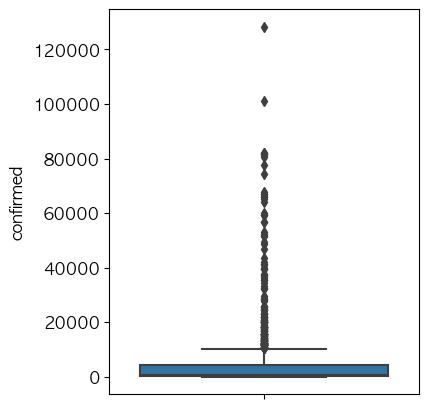

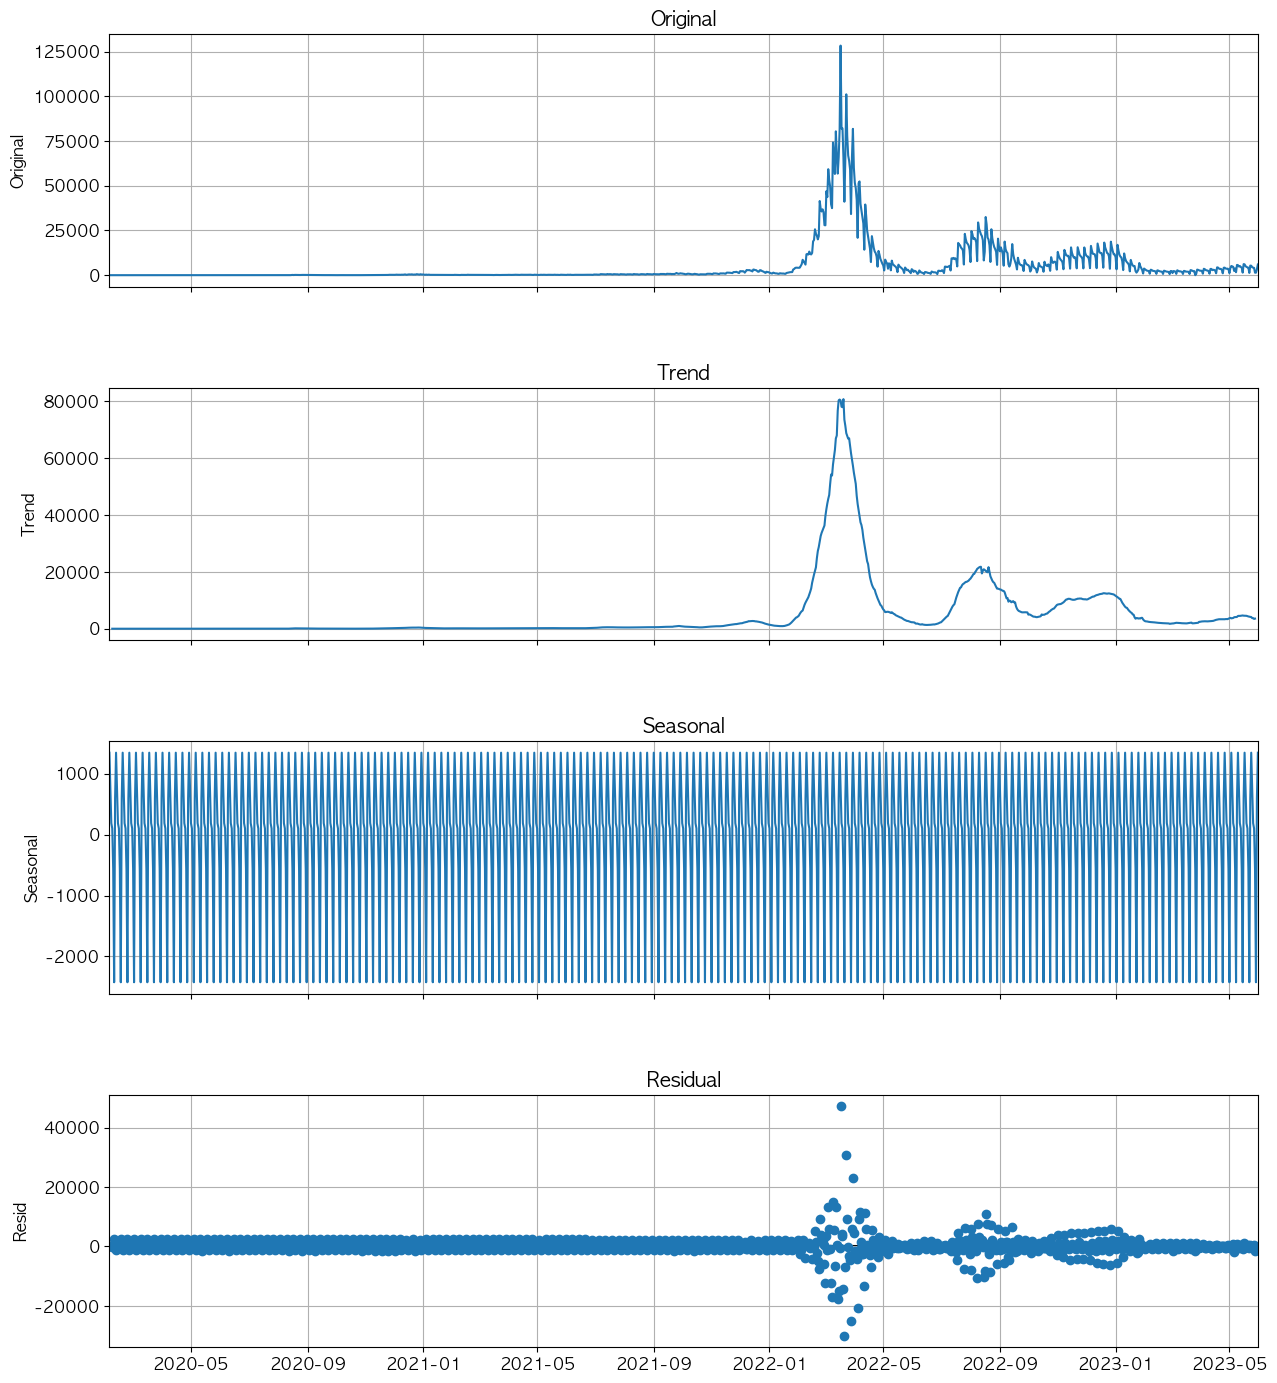

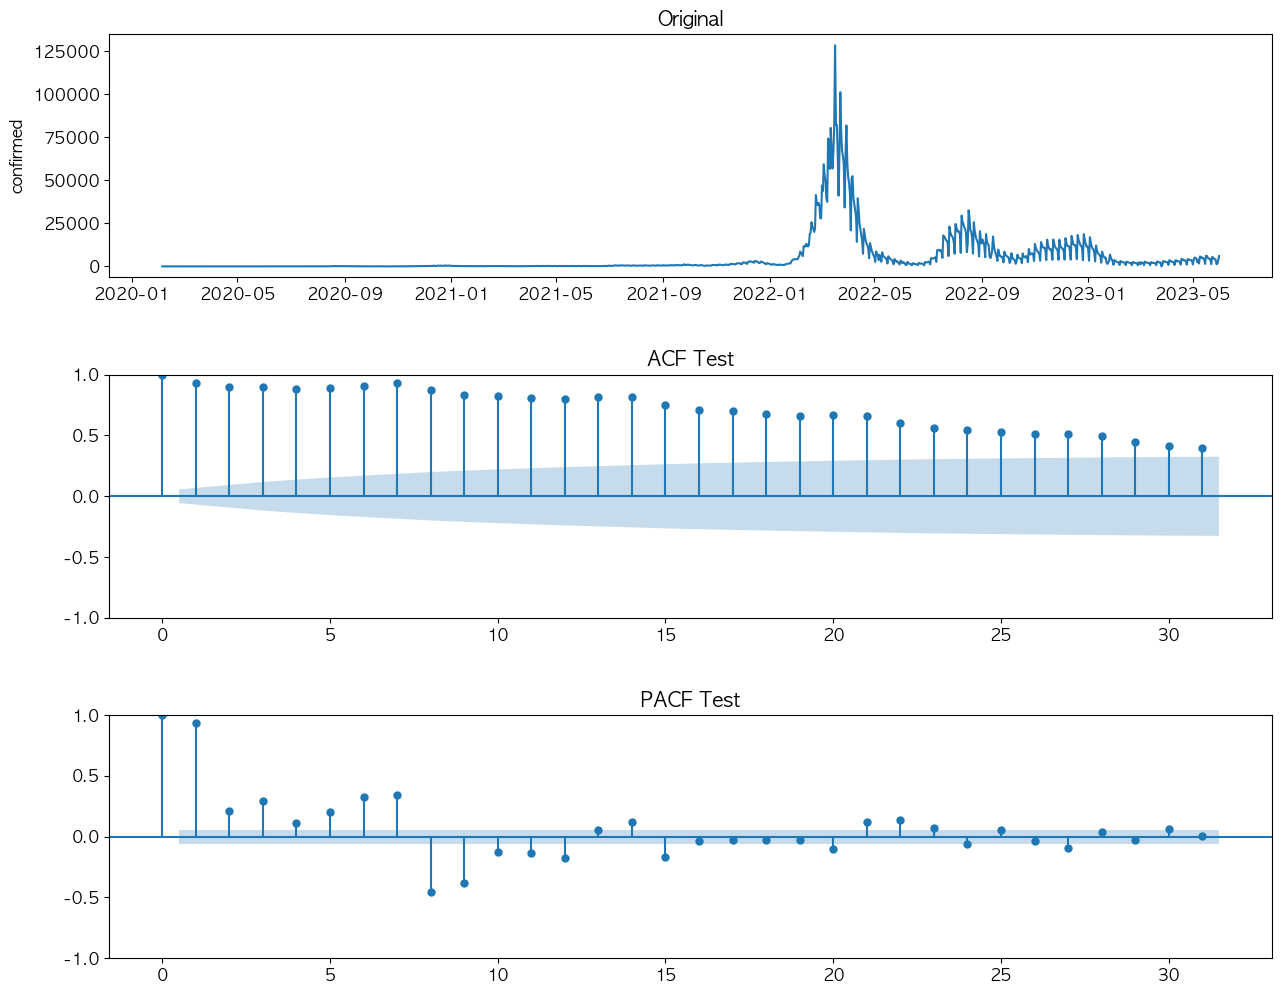

=========== 원본 데이터 ===========
+------------------------------------+-------------+
| ADF Test                           |             |
|------------------------------------+-------------|
| 검정통계량(ADF Statistic)          |    -4.11626 |
| 유의수준(p-value)                  | 0.000910279 |
| 최적차수(num of lags)              |          23 |
| 관측치 개수(num of observations)   |        1188 |
| 기각값(Critical Values) 1%         |    -3.43587 |
| 기각값(Critical Values) 5%         |    -2.86398 |
| 기각값(Critical Values) 10%        |    -2.56807 |
| 데이터 정상성 여부(0=Flase,1=True) |           1 |
+------------------------------------+-------------+


In [34]:
exp_time_data(data = df3, yname = 'confirmed', sd_model = 'a')

> ACF Test가 더 완만해 보이고 차분이 필요하지 않은 것 같으므로 AR(1) 모델로 결정

## 4. ARIMA (정석) 분석
### 1) 분석모델 만들기

In [35]:
model = ARIMA(df3['confirmed'], order=(1,0,0), seasonal_order=(1,0,0,7))
my_fit = model.fit()
print(my_fit.summary())

                                    SARIMAX Results                                    
Dep. Variable:                       confirmed   No. Observations:                 1212
Model:             ARIMA(1, 0, 0)x(1, 0, 0, 7)   Log Likelihood              -11572.350
Date:                         Mon, 07 Aug 2023   AIC                          23152.700
Time:                                 11:28:21   BIC                          23173.100
Sample:                             02-05-2020   HQIC                         23160.381
                                  - 05-31-2023                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5119.1137   2109.543      2.427      0.015     984.486    9253.742
ar.L1          0.7469      0.006    118.058      0.000     

### 2) 학습 데이터에 대한 예측치
- 학습한 데이터에 대한 `.predict()` 함수의 결과값을 내장하고 있다.

In [36]:
fv = my_fit.fittedvalues
fv.head()

2020-02-05    5119.113728
2020-02-06    1037.069411
2020-02-07     959.246109
2020-02-08     861.651300
2020-02-09     741.551582
Freq: D, dtype: float64

### 3) 학습한 내용을 토대로 이후 120일 간의 예상치 생성

In [37]:
fc = my_fit.forecast(120)
fc.head()

2023-06-01    5172.145642
2023-06-02    4877.622172
2023-06-03    4674.759819
2023-06-04    2668.118616
2023-06-05    2610.674342
Freq: D, Name: predicted_mean, dtype: float64

### 4) 시각화

In [38]:
# 날짜 (x축) 구하기
last = df3.index.max()
xmin = last-timedelta(days=120)
xmax = last+timedelta(days=120+10)
ymax = df3['confirmed'][xmin:xmax].max()
xmin, xmax, ymax

(Timestamp('2023-01-31 00:00:00'), Timestamp('2023-10-08 00:00:00'), 6198.0)

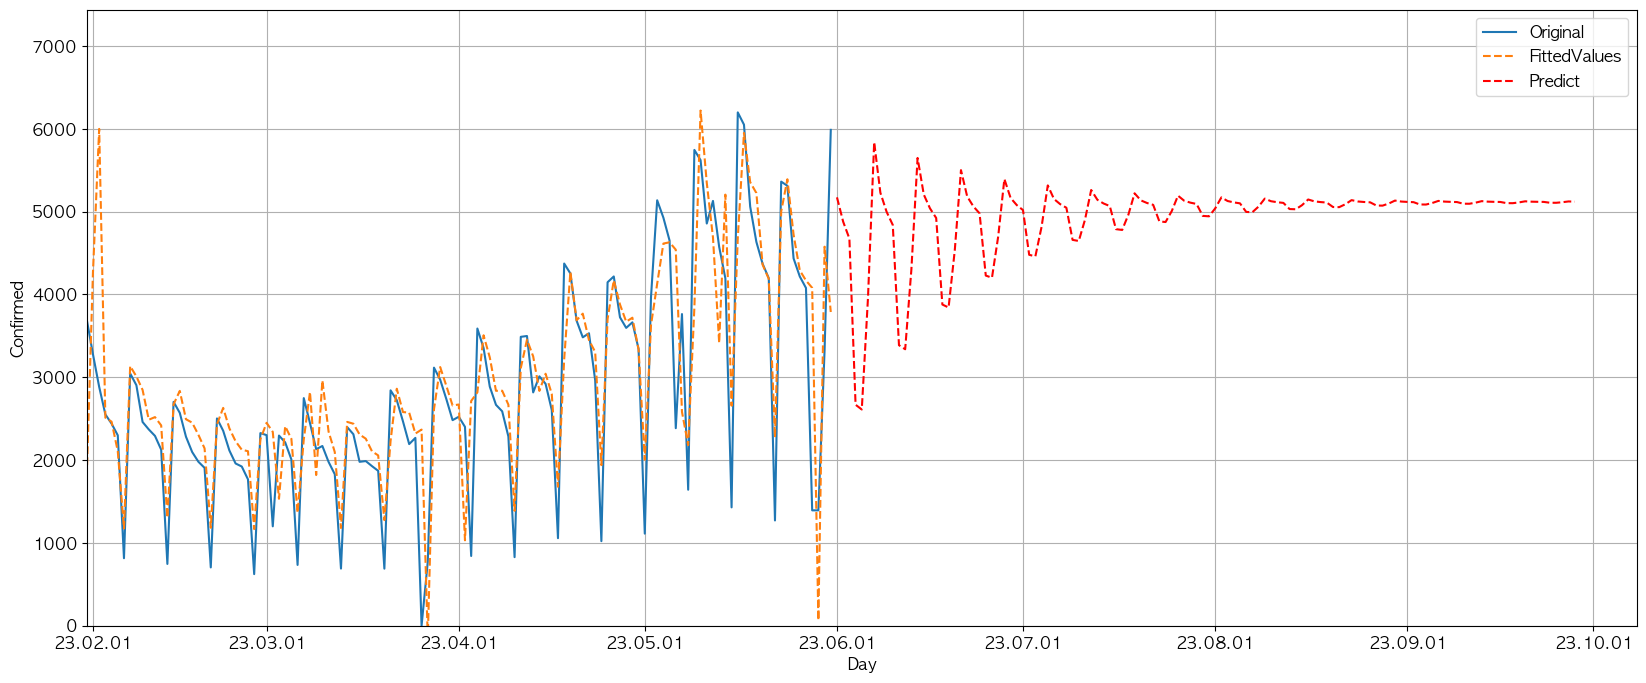

In [39]:
plt.figure(figsize = (20, 8))

# 원본 데이터
sb.lineplot(data=df3, x=df3.index, y='confirmed', label='Original')

# 원본에 대한 학습 결과
sb.lineplot(x=fv.index, y=fv.values, label='FittedValues', 
            linestyle='--')

# 향후 120일 간의 예측값
sb.lineplot(x=fc.index, y=fc.values, label='Predict', 
            linestyle='--', color='red')

plt.xlabel('Day')
plt.ylabel('Confirmed')
plt.legend()

plt.xlim([xmin, xmax])
plt.ylim([0, ymax*1.2])

# 그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()

## 5. AutoARIMA 분석
### 1) 분석 수행
- 수집한 데이터 전체를 적용

In [42]:
my_p = 1    # AR의 차수 (검증한 결과를 활용)
my_d = 0    # 차분 횟수 (검증한 결과를 활용)
my_q = 0    # MA의 차수 (검증한 결과를 활용)
my_s = 7    # 계절성 주기 (분석가가 판단)

model = auto_arima(y=df3['confirmed'],   # 모델링 하려는 시계열 데이터 또는 배열
                    start_p = 0,         # p의 시작점
                    max_p = my_p,        # p의 최댓값
                    d=my_d,              # 차분 횟수
                    start_q=0,           # q의 시작점
                    max_q=my_q,          # q의 최대값
                    seasonal=True,       # 계절성 사용 여부
                    m=my_s,              # 계절성 주기
                    start_P=0,           # P의 시작점
                    max_P=my_p,          # P의 최대값
                    D=my_d,              # 계절성 차분 횟수
                    start_Q=0,           # Q의 시작점
                    max_Q=my_q,          # Q의 최대값
                    trace=True           # 학습 과정 표시 여부
)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=26229.494, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=23152.696, Time=2.11 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=26427.372, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=23752.801, Time=0.07 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=23793.360, Time=1.11 sec
 ARIMA(1,0,0)(1,0,0)[7]             : AIC=23163.519, Time=0.90 sec

Best model:  ARIMA(1,0,0)(1,0,0)[7] intercept
Total fit time: 4.237 seconds
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1212
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 7)   Log Likelihood              -11572.348
Date:                           Mon, 07 Aug 2023   AIC                          23152.696
Time:                                   11:29:32   BIC                          23173.096
Sample:                     

### 2) 학습한 데이터와 동일 기간에 대한 예측치 산정
- `데이터프레임.fittedvalues()`

In [44]:
fv = model.fittedvalues()
fv

2020-02-05    4973.174026
2020-02-06    1006.831174
2020-02-07     931.237298
2020-02-08     836.454393
2020-02-09     719.834091
                 ...     
2023-05-27    4157.559852
2023-05-28    4069.155549
2023-05-29      54.794370
2023-05-30    4566.109290
2023-05-31    3777.414276
Freq: D, Length: 1212, dtype: float64

### 3) 향후 120일 간의 예측치
- `데이터프레임.predict(n_periods=n)`

In [45]:
fc = model.predict(n_periods=120)
fc.head()

2023-06-01    5161.763150
2023-06-02    4859.506173
2023-06-03    4650.853964
2023-06-04    2639.624599
2023-06-05    2578.940077
Freq: D, dtype: float64

### 4) 시각화

In [49]:
# 그래프의 x축 구하기
last = df3.index.max()
xmin = last-timedelta(days=120)
xmax = last+timedelta(days=120+10)
ymax = df3['confirmed'][xmin:xmax].max()
xmin, xmax, ymax

(Timestamp('2023-01-31 00:00:00'), Timestamp('2023-10-08 00:00:00'), 6198.0)

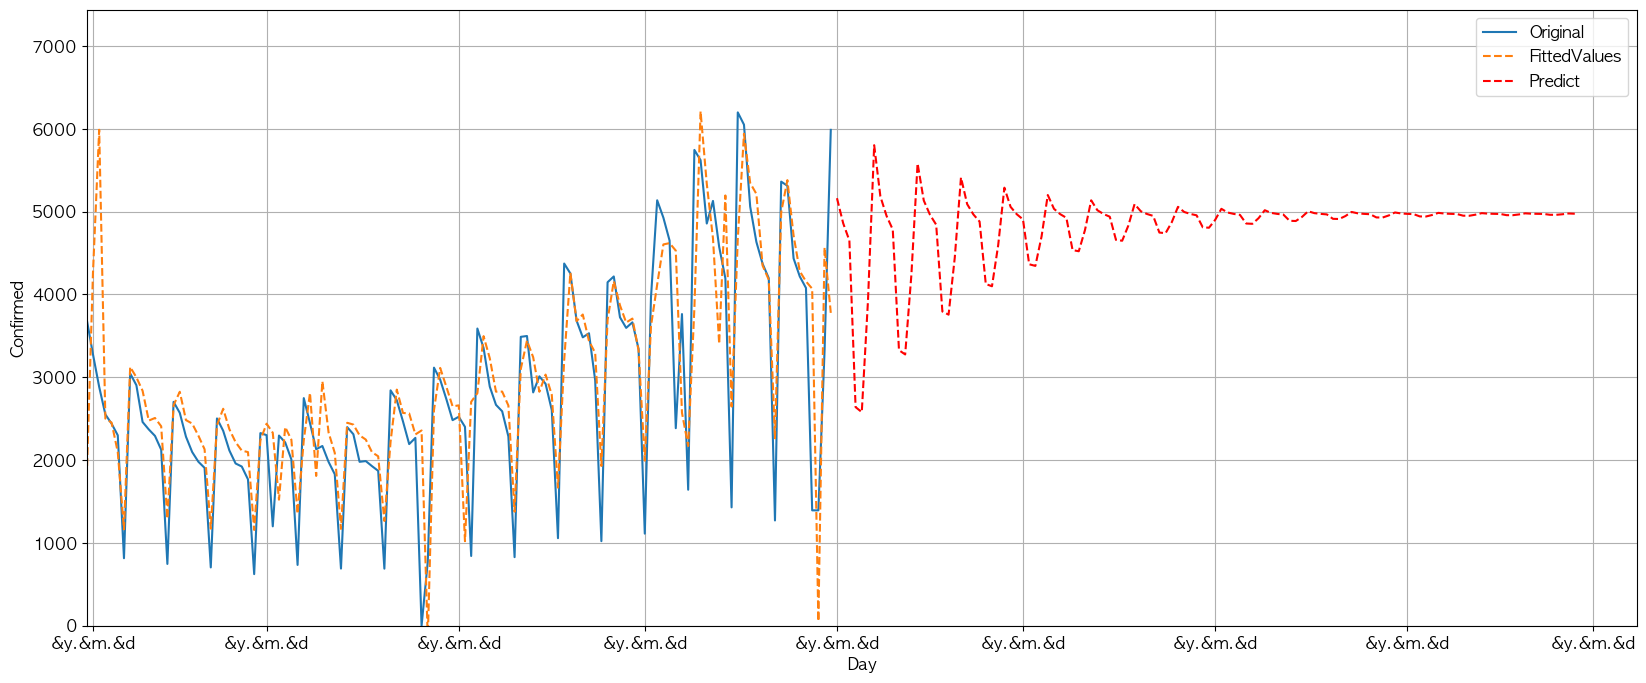

In [50]:
plt.figure(figsize = (20,8))

# 원본
sb.lineplot(data=df3, x=df3.index, y='confirmed', label='Original')

# 원본에 대한 학습결과
sb.lineplot(x=fv.index, y=fv.values, label='FittedValues', linestyle='--')

# 향후 120일 간의 예측값
sb.lineplot(x=fc.index, y=fc.values, 
            label='Predict', linestyle='--', color='red')

plt.xlabel('Day')
plt.ylabel('Confirmed')
plt.legend()

plt.xlim([xmin, xmax])
plt.ylim([0, ymax*1.2])

# 그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearFmt = mdates.DateFormatter('&y.&m.&d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()